# LinkSearch

In this colab, we present the main training pipeline

Additional steps for data preprocessing have been implemented in separate external python scripts, including
- ... (add files)
- ... (add files)
- ... (add files)

This notebook, we will (1) gain a better understanding of our augmented/modeled action relationship graph using DeepSNAP representations, (2) build a homogeneous graph to learn similarity search as a link prediction task, and (3) evaluate our approach against the baseline, which is compted in `baseline_similarity.py`. Specifically, we will evaluate these models on the the selected MetaVD action relation dataset.

## Setup

In [1]:
# imports
import os
import torch
import torch_geometric

print(torch.__version__)
print(torch.version.cuda)
print(torch_geometric.__version__)

/Users/shizhehe/miniforge3/envs/cs224w/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.1.1
None
2.4.0


## 0. Loading the Data

In [15]:
import utils
import csv
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

from utils import related_labels

In [30]:
class GraphLoader:
    def __init__(self, verbose=False) -> None:
        #each key is a label and each value is the label's id and also an array of the video ids
        self.labels = {}
        #never used but is a set of all used node_ids
        self.all_node_ids = set()
        #next id that will get assigned
        self.cur_id = 0
        #actual graph
        self.G = nx.Graph()
        #verbose printing
        self.verbose = verbose

    #give nodes an id for graph connections
    def get_id(self):
        self.all_node_ids.add(self.cur_id)
        r = self.cur_id
        self.cur_id+=1
        if self.cur_id % 1000:
            if self.verbose: 
                print("loaded id", self.cur_id)
        return r

    #iterate all in h5 and create nodes and store set of all nodes of each type
    def create_labels(self, data_h5):
        for key in data_h5.keys():
            l = data_h5[key]['label'].decode('utf-8')
            dataset = data_h5[key]['dataset'].decode('utf-8')
            unique_label = f'{l}-{dataset}'
            
            id = self.get_id()
            if unique_label in self.labels:
                self.labels[unique_label]['nodes'].append(id)
            else:
                self.labels[unique_label] = {}
                self.labels[unique_label]['nodes'] = [id]
                label_id = self.get_id()
                self.labels[unique_label]['label_id'] = label_id
                self.G.add_node(
                    label_id,
                    node_type='label',
                    label=unique_label
                )
                
            """ 
            print()
            for attribute in data_h5[key]:
                print(attribute)
                print(type(data_h5[key][attribute]))
            print()
            """
            self.G.add_node(
                id,
                node_type='video', 
                dataset=data_h5[key]['dataset'].decode('utf-8'), 
                label=data_h5[key]['label'].decode('utf-8'),
                split=data_h5[key]['split'].decode('utf-8'),
                num_frames=int(data_h5[key]['num_frames']),
                frame_indices=data_h5[key]['frame_indices'].tolist(),
                frames=data_h5[key]['frames'].tolist(),
                raw_path=data_h5[key]['raw_path'].decode('utf-8'),
                embeddings=data_h5[key]['embeddings'].tolist()
            )
            """
            self.G.add_node(
                id,
                node_type='video', 
                dataset=data_h5[key]['dataset'].decode('utf-8'), 
                label=data_h5[key]['label'].decode('utf-8'),
                split=data_h5[key]['split'].decode('utf-8'),
                num_frames=int(data_h5[key]['num_frames']),
                frame_indices=data_h5[key]['frame_indices'].tolist(),
                frames=data_h5[key]['frames'].tolist(),
                raw_path=data_h5[key]['raw_path'].decode('utf-8'),
                embeddings=data_h5[key]['embeddings'].tolist()
            )
            """
    
    #iterate all sets of types of nodes and create node and interconnect all nodes within the set
    def connect_videos(self):
        for unique_label in self.labels:
            for node_id in self.labels[unique_label]['nodes']:
                self.G.add_edge(self.labels[unique_label]['label_id'], node_id, relationship='video-to-label')
                for other_id in self.labels[unique_label]['nodes']:
                    if node_id != other_id:
                        self.G.add_edge(other_id, node_id, relationship='video-to-video')

    #iterate all csv connections and create virtual node connections
    def connect_labels(self, csv_path, include_is_a=True):
        #df_edges = pd.read_csv(csv_path, usecols=['from_action_name', 'to_action_name', 'relation'])
        df_edges = pd.read_csv(csv_path)
        for _, edge_data in df_edges.iterrows():
            relation = edge_data['relation']

            #is_a_labels = related_labels(metavd_df, true_label, dataset, 'is-a')
            #similar_labels = related_labels(metavd_df, true_label, dataset, 'similar')
            #equal_labels = related_labels(metavd_df, true_label, dataset, 'equal')

            if relation != 'is-a' or include_is_a:
                action_name_1 = f'{edge_data["from_action_name"]}-{edge_data["from_dataset"]}'
                action_name_2 = f'{edge_data["to_action_name"]}-{edge_data["to_dataset"]}'
                if action_name_1 in self.labels and action_name_2 in self.labels:
                    from_id = self.labels[action_name_1]['label_id']
                    to_id = self.labels[action_name_2]['label_id']
                    self.G.add_edge(from_id, to_id, relationship='label-to-label-'+relation)
                else:
                    if self.verbose:
                        if action_name_1 not in self.labels:
                            print(f'{action_name_1} not in self.labels')
                        if action_name_2 not in self.labels:
                            print(f'{action_name_2} not in self.labels')

    def create_graph(self, data_h5, csv, export_path, export=False):
        self.create_labels(data_h5)
        self.connect_videos()
        self.connect_labels(csv, include_is_a=True)
        if export:
            self.export_graph(export_path)

    #draw the graph
    def draw_graph(self):
        nx.draw(self.G, with_labels=True, font_weight='bold', node_size=300, node_color='skyblue', font_color='black', font_size=8)
        plt.show()

    def export_graph(self, export_path):
        G_export = nx.Graph()
        for node, attrs in self.G.nodes(data=True):
            converted_attrs = {key: str(value) for key, value in attrs.items()}
            G_export.add_node(node, **converted_attrs)

         # Export the new graph to GEXF
        nx.write_graphml(G_export, export_path)

Reading HDF5: 100%|██████████| 110/110 [00:00<00:00, 683.97samples/s]


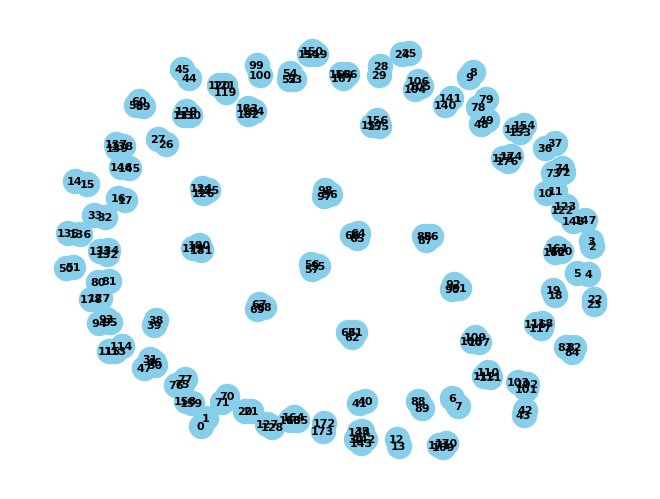

In [27]:
data_h5 = utils.read_h5("frames_data_small.h5")
metavd_path = 'metavd_v1.csv'

gl = GraphLoader()
gl.create_graph(data_h5=data_h5, csv=metavd_path, export_path='metavd_v1.graphml', export=False)
gl.draw_graph()

## 1. Network Visualization, Understanding the Data

In [32]:
import networkx as next
import matplotlib.pyplot as plt

# load video/node data into graph
data_h5 = utils.read_h5("frames_data_small.h5")
metavd_path = 'metavd_v1.csv'

gl = GraphLoader(verbose=False)
gl.create_graph(data_h5=data_h5, csv=metavd_path, export_path='metavd_v1.graphml')

Reading HDF5: 100%|██████████| 110/110 [00:00<00:00, 763.93samples/s]


/Users/shizhehe/miniforge3/envs/cs224w/lib/python3.9/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


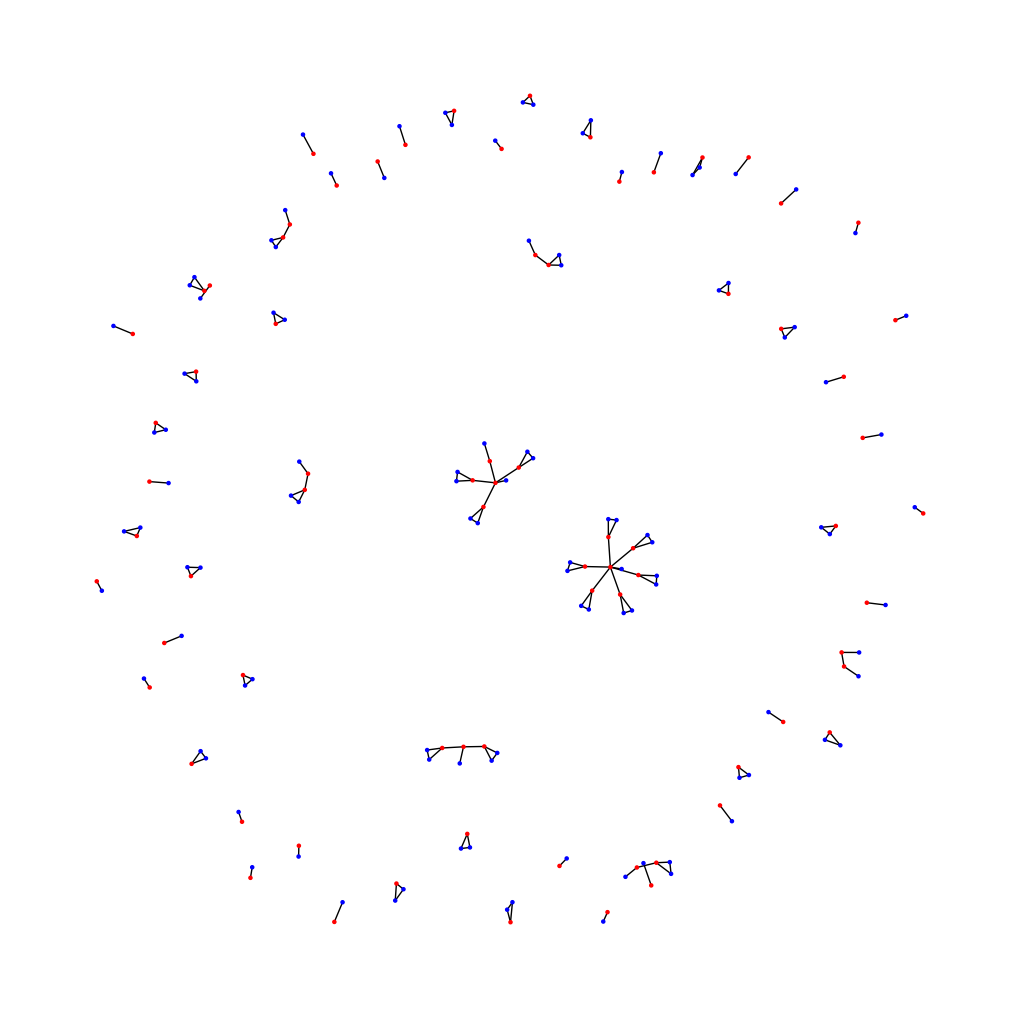

In [33]:
community_map = {}

for node in gl.G.nodes(data=True):
    community_map[node[0]] = node[1]["node_type"]

color_map = {"video": "blue", "label": "red"}
node_color = [color_map[community_map[node]] for node in gl.G.nodes()]
pos = nx.spring_layout(gl.G)
plt.figure(figsize=(10, 10))
nx.draw(gl.G, pos=pos, node_color=node_color, cmap=plt.get_cmap('coolwarm'), node_size=5)
plt.show()

In [55]:
# stats
print(f'Number of nodes: {gl.G.number_of_nodes()}')
print(f'Number of edges: {gl.G.number_of_edges()}')
print(f'Number of labels: {len(gl.labels)}')
print(f'Average amount of nodes per label: {gl.G.number_of_nodes()/len(gl.labels)}')

print(f'Number of label-to-label similar relations: {len([x for x in nx.get_edge_attributes(gl.G, "relationship").values() if x == "label-to-label-similar"])}')
print(f'Number of label-to-label is-a relations: {len([x for x in nx.get_edge_attributes(gl.G, "relationship").values() if x == "label-to-label-is-a"])}')
print(f'Number of label-to-label equal relations: {len([x for x in nx.get_edge_attributes(gl.G, "relationship").values() if x == "label-to-label-equal"])}')


Number of nodes: 185
Number of edges: 162
Number of labels: 75
Average amount of nodes per label: 2.466666666666667
Number of label-to-label similar relations: 2
Number of label-to-label is-a relations: 13
Number of label-to-label equal relations: 2
